In [25]:
%matplotlib widget
import caiman as cm
import numpy as np
import matplotlib.pyplot as plt
from caiman.source_extraction import cnmf
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from caiman.utils.visualization import inspect_correlation_pnr, nb_inspect_correlation_pnr
from caiman.source_extraction.cnmf import params as params
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.utils.visualization import view_quilt

In [26]:
movie_path = "C:/Users/sangeetha/Courses/Intro-To-Calcium-Imaging-Analysis/data/data_endoscope.tif"
print(movie_path)

C:/Users/sangeetha/Courses/Intro-To-Calcium-Imaging-Analysis/data/data_endoscope.tif


In [27]:
movie_orig = cm.load(movie_path)
cm.play_movie(movie_orig, plot_text=True)

In [28]:
# Summary image (max projection)
plt.imshow(np.max(movie_orig, axis=0))

In [29]:
# Summary image (correlation)
corr_img = cm.local_correlations(movie_orig, swap_dim=False)
plt.imshow(corr_img)

In [30]:
mc = MotionCorrect(fname=movie_path)
mc.motion_correct(save_movie=True)

In [31]:
movie_corr = cm.load(mc.mmap_file)
cm.play_movie(movie_corr)

100%|██████████| 1/1 [00:00<00:00, 21.84it/s]


In [32]:
# dataset dependent parameters
frate = 10                       # movie frame rate
decay_time = 0.4                 # length of a typical transient in seconds

# motion correction parameters
motion_correct = True    # flag for performing motion correction
pw_rigid = False         # flag for performing piecewise-rigid motion correction (otherwise just rigid)
gSig_filt = (3, 3)       # sigma for high pass spatial filter applied before motion correction, used in 1p data
max_shifts = (5, 5)      # maximum allowed rigid shift
strides = (48, 48)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # overlap between patches (size of patch = strides + overlaps)
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'      # replicate values along the boundaries

mc_dict = {
    'fnames': movie_path,
    'fr': frate,
    'decay_time': decay_time,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan
}

parameters = params.CNMFParams(params_dict=mc_dict)

In [33]:
if motion_correct:
    # do motion correction rigid
    mot_correct = MotionCorrect(movie_path, **parameters.get_group('motion'))
    mot_correct.motion_correct(save_movie=True)
    fname_mc = mot_correct.fname_tot_els if pw_rigid else mot_correct.fname_tot_rig
    if pw_rigid:
        bord_px = np.ceil(np.maximum(np.max(np.abs(mot_correct.x_shifts_els)),
                                     np.max(np.abs(mot_correct.y_shifts_els)))).astype(int)
    else:
        bord_px = np.ceil(np.max(np.abs(mot_correct.shifts_rig))).astype(int)
        # Plot shifts
        plt.plot(mot_correct.shifts_rig)  # % plot rigid shifts
        plt.legend(['x shifts', 'y shifts'])
        plt.xlabel('frames')
        plt.ylabel('pixels')
        plt.gcf().set_size_inches(6,3)

    bord_px = 0 if border_nan == 'copy' else bord_px
    fname_new = cm.save_memmap(fname_mc, base_name='memmap10_', order='C',
                               border_to_0=bord_px)
else:  # if no motion correction just memory map the file
    fname_new = cm.save_memmap(movie_path, base_name='memmap_',
                               order='C', border_to_0=0)

In [34]:
# load mmap file 
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

In [11]:
plt.imshow(images[0])

In [35]:
# parameters for source extraction and deconvolution
p = 1               # order of the autoregressive system
K = None            # upper bound on number of components per patch, in general None for CNMFE
gSig = np.array([3, 3])  # expected half-width of neurons in pixels 
gSiz = 2*gSig + 1     # half-width of bounding box created around neurons during initialization
merge_thr = .7      # merging threshold, max correlation allowed
rf = 40             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 20    # amount of overlap between the patches in pixels 
tsub = 2            # downsampling factor in time for initialization, increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization, increase if you have memory problems
gnb = 0             # number of background components (rank) if positive, set to 0 for CNMFE
low_rank_background = None  # None leaves background of each patch intact (use True if gnb>0)
nb_patch = 0        # number of background components (rank) per patch (0 for CNMFE)
min_corr = .8       # min peak value from correlation image
min_pnr = 10        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background (increase to 2 if slow)
ring_size_factor = 1.4  # radius of ring is gSiz*ring_size_factor

parameters.change_params(params_dict={'method_init': 'corr_pnr',  # use this for 1 photon
                                'K': K,
                                'gSig': gSig,
                                'gSiz': gSiz,
                                'merge_thr': merge_thr,
                                'p': p,
                                'tsub': tsub,
                                'ssub': ssub,
                                'rf': rf,
                                'stride': stride_cnmf,
                                'only_init': True,    # set it to True to run CNMF-E
                                'nb': gnb,
                                'nb_patch': nb_patch,
                                'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
                                'low_rank_background': low_rank_background,
                                'update_background_components': True,  # sometimes setting to False improve the results
                                'min_corr': min_corr,
                                'min_pnr': min_pnr,
                                'normalize_init': False,               # just leave as is
                                'center_psf': True,                    # True for 1p
                                'ssub_B': ssub_B,
                                'ring_size_factor': ring_size_factor,
                                'del_duplicates': True,                # whether to remove duplicates from initialization
                                'border_pix': bord_px});                # number of pixels to not consider in the borders)

In [36]:
cnmfe_model = cnmf.CNMF(n_processes=1, 
                        params=parameters)

In [37]:
print(gSig)
gsig_tmp = (3,3)
correlation_image, peak_to_noise_ratio = cm.summary_images.correlation_pnr(images[::max(T//1000, 1)], # subsample if needed
                                                                           gSig=gsig_tmp[0], # used for filter
                                                                           swap_dim=False) # change swap dim if output looks we

[3 3]


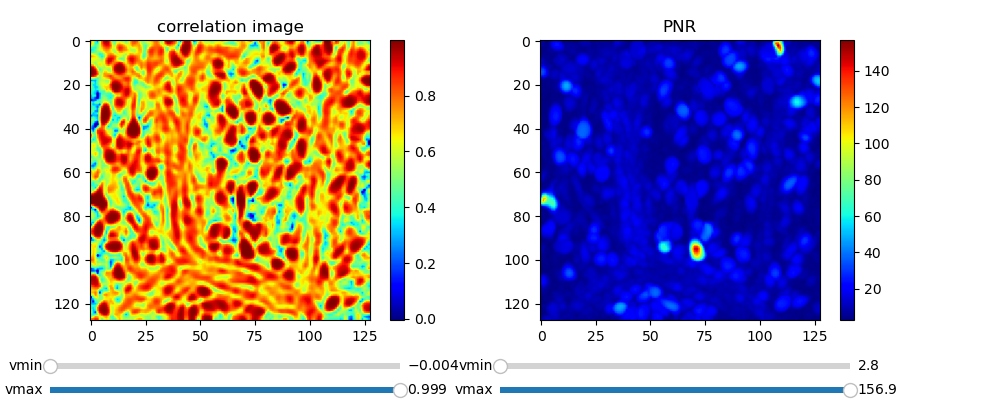

In [17]:
inspect_correlation_pnr(correlation_image, peak_to_noise_ratio) # Not showing plots

In [38]:
gsig_new = gSig # unchanged
min_corr_new  = 0.85 
min_pnr_new = 12     

cnmfe_model.params.change_params(params_dict={'gSig': gsig_new,
                                              'min_corr': min_corr_new, 
                                              'min_pnr': min_pnr_new});

Patch width: 81 , Stride: 60, Overlap: 21


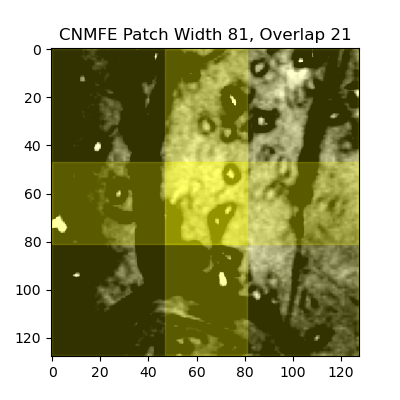

In [19]:
# calculate stride and overlap from parameters
cnmfe_patch_width = cnmfe_model.params.patch['rf']*2 + 1
cnmfe_patch_overlap = cnmfe_model.params.patch['stride'] + 1
cnmfe_patch_stride = cnmfe_patch_width - cnmfe_patch_overlap
print(f'Patch width: {cnmfe_patch_width} , Stride: {cnmfe_patch_stride}, Overlap: {cnmfe_patch_overlap}');

# plot the patches
patch_ax = view_quilt(corr_img, 
                      cnmfe_patch_stride, 
                      cnmfe_patch_overlap, 
                      vmin=np.percentile(np.ravel(corr_img), 50), 
                      vmax=np.percentile(np.ravel(corr_img), 99.5),
                      color='yellow',
                      figsize=(4,4));
patch_ax.set_title(f'CNMFE Patch Width {cnmfe_patch_width}, Overlap {cnmfe_patch_overlap}');

In [39]:
cnmfe_model.fit(images)

c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


In [40]:
cnmfe_model.estimates.C.shape

(96, 1000)

In [21]:
min_SNR = 3            # SNR threshold
rval_thr = 0.85    # spatial correlation threshold

quality_params = {'min_SNR': min_SNR,
                  'rval_thr': rval_thr,
                  'use_cnn': False}
cnmfe_model.params.change_params(params_dict=quality_params)

cnmfe_model.estimates.evaluate_components(images, cnmfe_model.params)

print('*****')
print(f"Total number of components: {len(cnmfe_model.estimates.C)}")
print(f"Number accepted: {len(cnmfe_model.estimates.idx_components)}")
print(f"Number rejected: {len(cnmfe_model.estimates.idx_components_bad)}")

*****
Total number of components: 96
Number accepted: 82
Number rejected: 14


In [23]:
cnmfe_model.estimates.plot_contours_nb(img=corr_img, 
                                       idx=cnmfe_model.estimates.idx_components);

In [24]:
cnmfe_model.params

CNMFParams:

data:

{'caiman_version': '1.9.16',
 'decay_time': 0.4,
 'dims': (128, 128),
 'dxy': (1, 1),
 'fnames': ['C:/Users/sangeetha/Courses/Intro-To-Calcium-Imaging-Analysis/data/data_endoscope.tif'],
 'fr': 10,
 'last_commit': 'GITW-1f7104c60f9c90698383dc3d7a912648e528b156',
 'mmap_C': None,
 'mmap_F': None,
 'var_name_hdf5': 'mov'}

spatial_params:

{'block_size_spat': 5000,
 'dist': 3,
 'expandCore': array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]]),
 'extract_cc': True,
 'maxthr': 0.1,
 'medw': None,
 'method_exp': 'dilate',
 'method_ls': 'lasso_lars',
 'n_pixels_per_process': 16384,
 'nb': 0,
 'normalize_yyt_one': True,
 'nrgthr': 0.9999,
 'num_blocks_per_run_spat': 20,
 'se': None,
 'ss': None,
 'thr_method': 'nrg',
 'update_background_components': True}

temporal_params:

{'ITER': 2,
 'bas_nonneg': False,
 'block_size_temp': 5000,
 'fudge_factor': 0.96,
 'lags': 5,
 'memory_efficient': False,
 'method_d